In [1]:
print("Hello World!")

Hello World!


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR



## WHEAT CSV

In [3]:
wheat_punjab=pd.read_csv("C:\Desktop\Smart Irrigation System\Punjab, India\wheat_punjab_daily_data.csv")

In [4]:
wheat_punjab.head(2)

,date,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),soil_moisture_28_to_100cm (m³/m³),shortwave_radiation_instant (W/m²),crop,Kc,ETc (mm)
0,2020-01-01,9.795833,87.666667,0.0,1.54,5.179167,13.508333,0.3265,2948.4,Wheat,0.35,0.5390
1,2020-01-02,11.625000,77.166667,0.0,1.63,6.362500,13.475000,0.3260,2763.3,Wheat,0.35,0.5705


In [5]:
 #Set the date column as the index
wheat_punjab.set_index('date', inplace=True)
# Ensure the index is in datetime format
wheat_punjab.index = pd.to_datetime(wheat_punjab.index)



## Examine Historical Soil Moisture Data


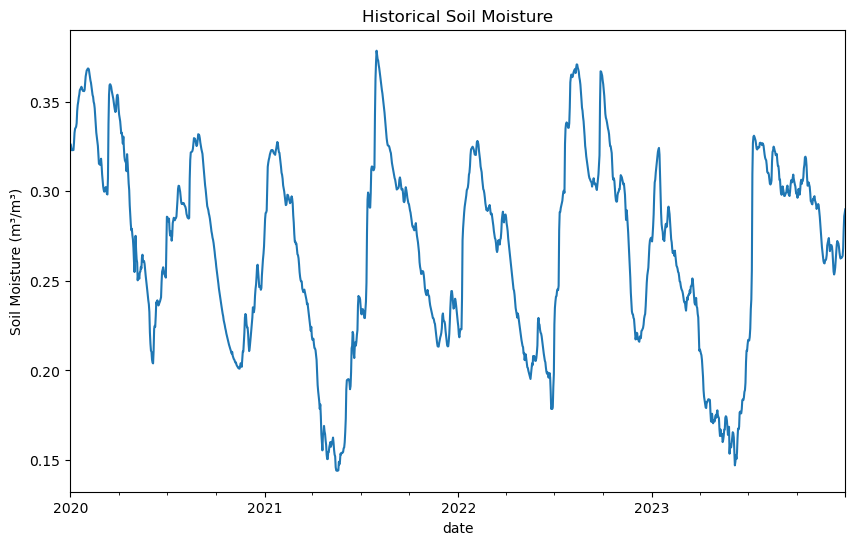

count    1461.000000
mean        0.267997
std         0.054200
min         0.144000
25%         0.227000
50%         0.273792
75%         0.307500
max         0.378458
Name: soil_moisture_28_to_100cm (m³/m³), dtype: float64

In [6]:
# Plot historical soil moisture data
wheat_punjab['soil_moisture_28_to_100cm (m³/m³)'].plot(figsize=(10, 6), title='Historical Soil Moisture')
plt.ylabel('Soil Moisture (m³/m³)')
plt.show()

# Describe the soil moisture data
wheat_punjab['soil_moisture_28_to_100cm (m³/m³)'].describe()



## Calculate Lagged Soil Moisture


In [7]:
# Calculate lagged soil moisture (1 day lag)
wheat_punjab['soil_moisture_lag1'] = wheat_punjab['soil_moisture_28_to_100cm (m³/m³)'].shift(1)

# Drop any rows with missing values
wheat_punjab.dropna(inplace=True)


In [8]:
wheat_punjab_historical=wheat_punjab.copy()

In [9]:
wheat_punjab.drop(columns=["crop", "soil_moisture_28_to_100cm (m³/m³)"], inplace=True)
# Dropping the specified columns
wheat_punjab = wheat_punjab.drop(columns=['Kc', 'ETc (mm)'])


## Integrating Lagged Soil Moisture into the Forecast Model


In [10]:
#Ensure dataset includes the lagged soil moisture 
wheat_punjab.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)', 'precipitation (mm)',
       'ET₀ (mm)', 'wind_speed_10m (km/h)',
       'soil_temperature_28_to_100cm (°C)',
       'shortwave_radiation_instant (W/m²)', 'soil_moisture_lag1'],
      dtype='object')

## Check Stationarity and Differencing


In [11]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary, differencing needed")

# Check for each column in the dataset
for column in wheat_punjab.columns:
    print(f'Checking stationarity for {column}')
    check_stationarity(wheat_punjab[column])

# Apply differencing if needed
wheat_punjab_diff = wheat_punjab.diff().dropna()

# Re-check stationarity after differencing
for column in wheat_punjab_diff.columns:
    print(f'Checking stationarity for differenced {column}')
    check_stationarity(wheat_punjab_diff[column])



Checking stationarity for temperature_2m (°C)


ADF Statistic: -2.2925692081833473
p-value: 0.17437575104163572
The series is not stationary, differencing needed
Checking stationarity for relative_humidity_2m (%)
ADF Statistic: -4.346049929508016
p-value: 0.00036935140337170135
The series is stationary
Checking stationarity for precipitation (mm)
ADF Statistic: -18.21901123672933
p-value: 2.382404563379795e-30
The series is stationary
Checking stationarity for ET₀ (mm)
ADF Statistic: -2.743239567835732
p-value: 0.0668501164434031
The series is not stationary, differencing needed
Checking stationarity for wind_speed_10m (km/h)
ADF Statistic: -4.868534010761584
p-value: 4.0141197043713764e-05
The series is stationary
Checking stationarity for soil_temperature_28_to_100cm (°C)
ADF Statistic: -3.7908532337844965
p-value: 0.00300229706413799
The series is stationary
Checking stationarity for shortwave_radiation_instant (W/m²)
ADF Statistic: -2.758586379700223
p-value: 0.06443723498701022
The series is not stationary, differencing needed


## Fitting Vector Autoregresion (VAR) Time series Model


In [12]:
""""Using this because it take multiple variables simultaneously"""

'"Using this because it take multiple variables simultaneously'

In [13]:
## Fit the VAR model to the differenced data.
# Fit the VAR model
model = VAR(wheat_punjab_diff)
model_fit = model.fit(maxlags=15, ic='aic')

# Summary of the model
model_fit.summary()


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     09:40:42
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    1.16374
Nobs:                     1452.00    HQIC:                  0.124161
Log likelihood:          -15667.3    FPE:                   0.609976
AIC:                    -0.494659    Det(Omega_mle):        0.448262
--------------------------------------------------------------------
Results for equation temperature_2m (°C)
                                           coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------
const                                         0.001279         0.030678            0.042           0.967
L1.temperature_2m (°C)                        0.058410 

##  Forecast Future Values

In [14]:
# Forecast the next 365 days
forecast_steps = 90
forecast = model_fit.forecast(wheat_punjab_diff.values[-model_fit.k_ar:], steps=forecast_steps)

# Create a DataFrame for the forecast
forecast_index = pd.date_range(start=wheat_punjab.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=wheat_punjab.columns)

# Reverse the differencing to get the actual forecasted values
forecast_df = wheat_punjab.iloc[-1] + forecast_df.cumsum()


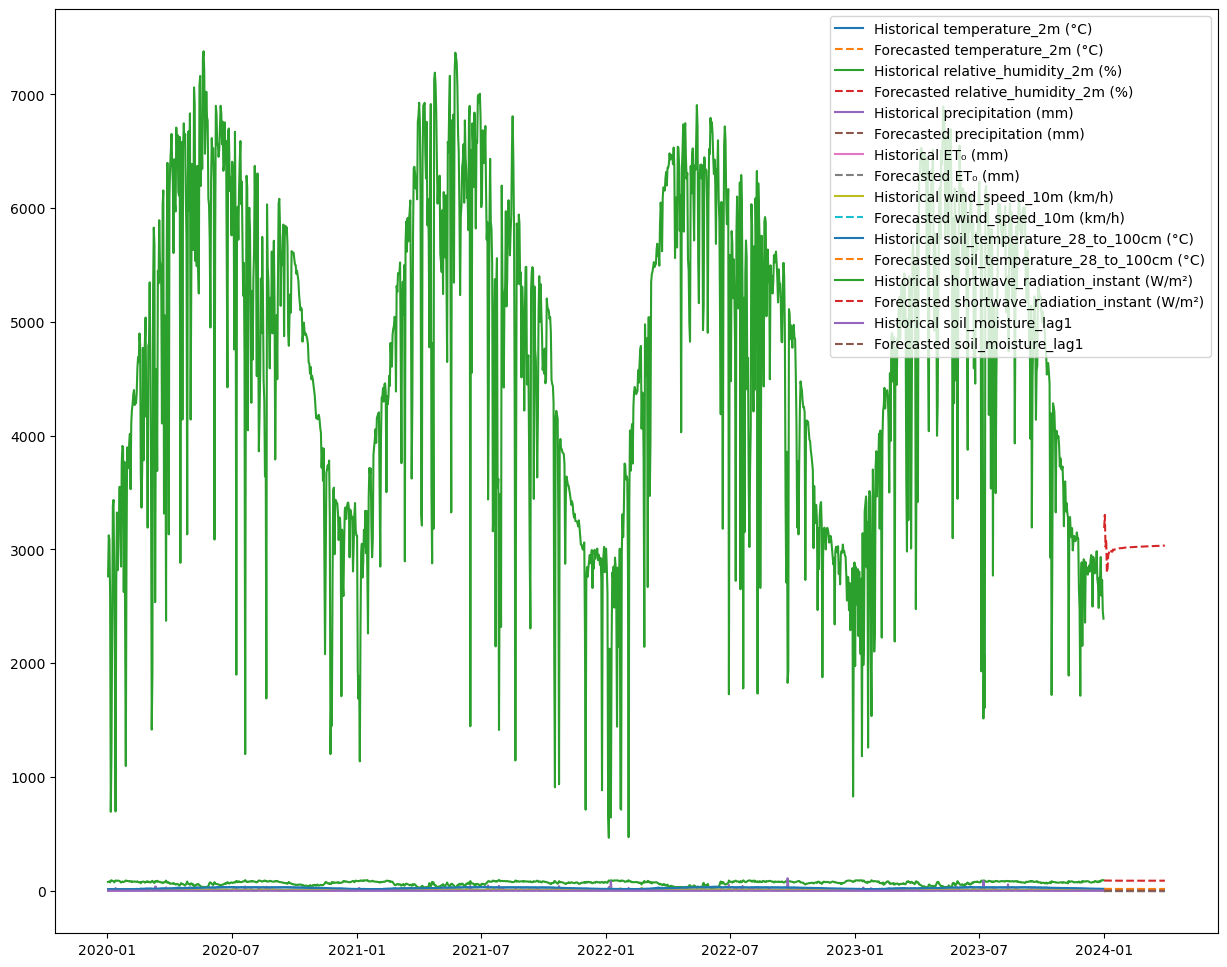

In [15]:
# Plot the forecast
plt.figure(figsize=(15, 12))
for column in forecast_df.columns:
    plt.plot(wheat_punjab.index, wheat_punjab[column], label=f'Historical {column}')
    plt.plot(forecast_df.index, forecast_df[column], label=f'Forecasted {column}', linestyle='--')
plt.legend()
plt.show()

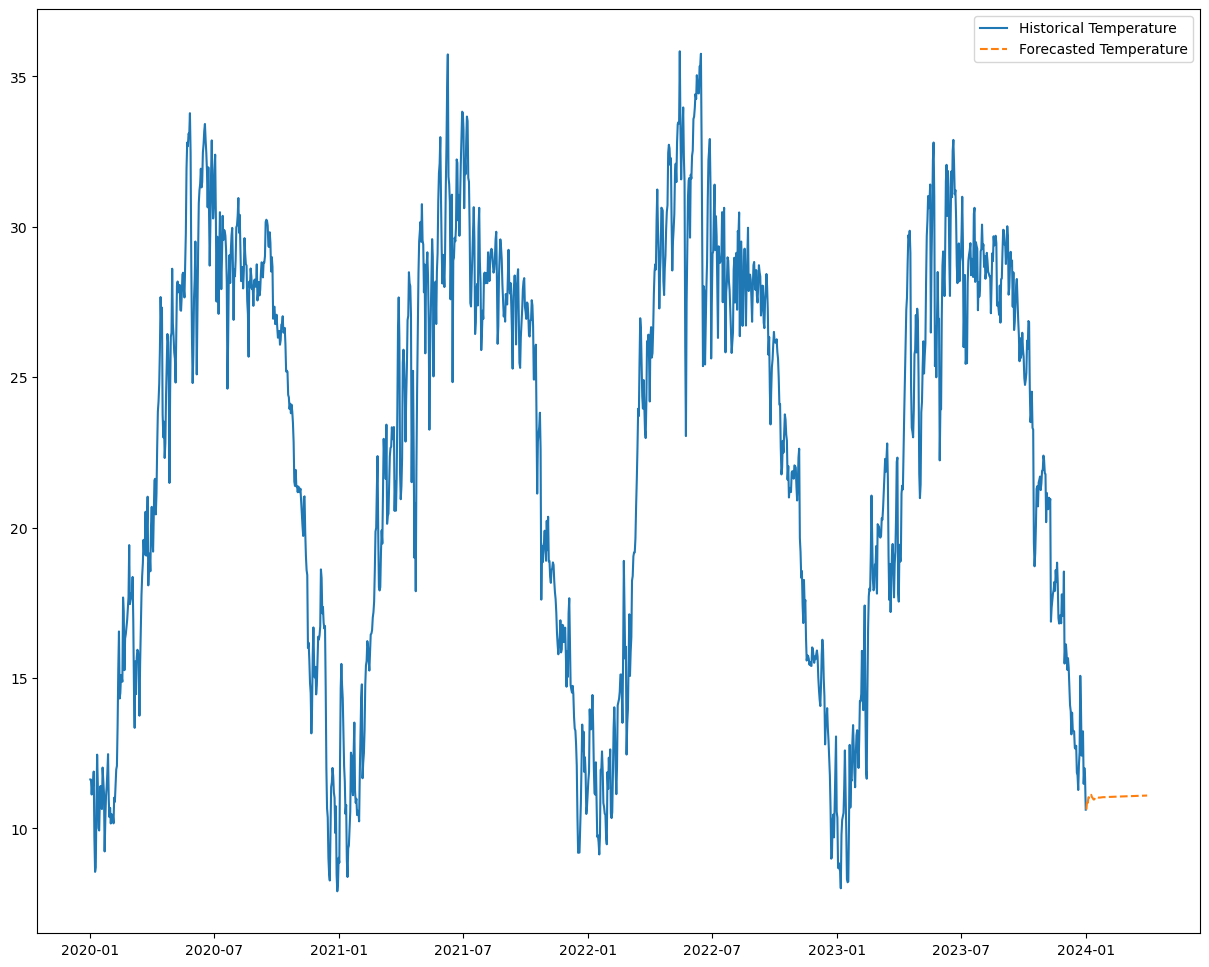

In [16]:
plt.figure(figsize=(15, 12))
plt.plot(wheat_punjab.index, wheat_punjab["temperature_2m (°C)"], label=f'Historical Temperature')
plt.plot(forecast_df.index, forecast_df["temperature_2m (°C)"], label=f'Forecasted Temperature', linestyle='--')
plt.legend()
plt.show()

## Model Evaluation 

In [17]:
 #If actual future data is available, compare it with the forecast
# actual_future_data = ... # Replace with actual future data if available

# Example metrics calculation if actual future data is available
# mae = mean_absolute_error(actual_future_data, forecasted_values)
# mse = mean_squared_error(actual_future_data, forecasted_values)
# rmse = np.sqrt(mse)
# mape = np.mean(np.abs((actual_future_data - forecasted_values) / actual_future_data)) * 100

# print(f"MAE: {mae}")
# print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")
# print(f"MAPE: {mape}")

## Predicting Soil Moisture based on Forecasted Weather

In [18]:
# Example of fitting the model (you would use your pre-trained model instead)

#wheat_punjab_historical
X_train = wheat_punjab_historical[['ET₀ (mm)', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'precipitation (mm)', 'wind_speed_10m (km/h)', 'soil_temperature_28_to_100cm (°C)', 'shortwave_radiation_instant (W/m²)', 'soil_moisture_lag1']]
#X_train = wheat_punjab_historical[['ET₀ (mm)', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'precipitation (mm)', 'wind_speed_10m (km/h)', 'soil_temperature_28_to_100cm (°C)', 'shortwave_radiation_instant (W/m²)', 'soil_moisture_lag1']]
y_train = wheat_punjab_historical['soil_moisture_28_to_100cm (m³/m³)']
irrigation_model = LinearRegression().fit(X_train, y_train)

# Predict future soil moisture using the forecasted weather parameters
features = ['ET₀ (mm)', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'precipitation (mm)', 'wind_speed_10m (km/h)', 'soil_temperature_28_to_100cm (°C)', 'shortwave_radiation_instant (W/m²)', 'soil_moisture_lag1']
forecast_df['predicted_soil_moisture'] = irrigation_model.predict(forecast_df[features])

In [19]:
forecast_df

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),shortwave_radiation_instant (W/m²),soil_moisture_lag1,predicted_soil_moisture
2024-01-01,10.625511,89.646062,-4.412988,1.652707,3.679133,16.048996,3188.514380,0.290157,0.290792
2024-01-02,10.926676,88.561988,-5.397321,1.751605,4.133428,15.925805,3303.775552,0.292393,0.292713
2024-01-03,10.846769,88.456751,-3.911883,1.533675,3.743703,15.822698,3023.131768,0.293571,0.294090
2024-01-04,11.035441,88.582695,-3.240123,1.640038,4.156977,15.728474,3089.358975,0.293876,0.294521
2024-01-05,11.018991,88.782506,-3.171889,1.523775,4.506323,15.644297,2796.657598,0.294456,0.295305
...,...,...,...,...,...,...,...,...,...
2024-03-26,11.087867,87.715314,-4.583410,1.715592,4.000382,14.996819,3032.793384,0.298635,0.299109
2024-03-27,11.088685,87.718716,-4.588920,1.715778,3.998793,14.997906,3033.050980,0.298615,0.299090
2024-03-28,11.089502,87.722120,-4.594430,1.715964,3.997204,14.998994,3033.308483,0.298596,0.299071
2024-03-29,11.090319,87.725526,-4.599938,1.716150,3.995616,15.000083,3033.565903,0.298577,0.299052


In [20]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the historical soil moisture line
fig.add_trace(go.Scatter(
    x=wheat_punjab_historical.index, 
    y=wheat_punjab_historical["soil_moisture_28_to_100cm (m³/m³)"],
    mode='lines',
    name='Historical Soil Moisture'
))

# Add the forecasted soil moisture line
fig.add_trace(go.Scatter(
    x=forecast_df.index, 
    y=forecast_df["predicted_soil_moisture"],
    mode='lines',
    name='Forecasted Soil Moisture',
    line=dict(dash='dash')  # This creates a dashed line
))

# Update layout for the figure
fig.update_layout(
    title='Soil Moisture Over Time With Prediction',
    xaxis_title='Date',
    yaxis_title='Soil Moisture (m³/m³)',
    legend_title='Legend',
    template='plotly_white',  # Optional: set a template
    width=900,  # Width of the plot
    height=700  # Height of the plot
)

# Show the figure
fig.show()


## Calculating Soil Deficit & Irrigation Need &   Irrigation Amount

In [21]:
# Calculate soil deficit
threshold_soil_moisture = 0.297715  # Example threshold in m³/m³ (mean of soil moisture predicted )
forecast_df['soil_deficit'] = forecast_df['ETc (mm)'] - forecast_df['precipitation (mm)']

# Define a function to calculate irrigation need
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

# Apply the irrigation calculation to the forecasted data
forecast_df['irrigation_amount'] = forecast_df.apply(lambda row: calculate_irrigation_need(
    row['predicted_soil_moisture'], threshold_soil_moisture, row['soil_deficit']), axis=1)



KeyError: 'ETc (mm)'

In [ ]:

# Calculate irrigation need
threshold_soil_moisture = 0.297715
# Calculate soil deficit
forecast_df['soil_deficit'] = forecast_df['ETc (mm)'] - forecast_df['precipitation (mm)']
forecast_df['irrigation_need'] = forecast_df['predicted_soil_moisture'] < threshold_soil_moisture
forecast_df['irrigation_amount'] = forecast_df.apply(
    lambda row: max(0, threshold_soil_moisture - row['predicted_soil_moisture']), axis=1
)

# Display the irrigation schedule

#irrigation_schedule = forecast_df[['predicted_soil_moisture', 'soil_deficit', 'irrigation_amount']]
#print(irrigation_schedule)



# Create and display the irrigation schedule
#irrigation_schedule = forecast_df[['predicted_soil_moisture', 'irrigation_amount']]
#irrigation_schedule.tail(50)

In [ ]:
forecast_df.head(10)

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),shortwave_radiation_instant (W/m²),Kc,ETc (mm),soil_moisture_lag1,predicted_soil_moisture,soil_deficit,irrigation_amount,irrigation_need
2024-01-01,10.534892,89.860850,-4.209284,1.682507,3.888398,16.045387,3153.465532,1.105857,1.689327,0.290555,0.291299,5.898611,0.006416,True
2024-01-02,10.681555,89.235005,-5.521353,1.708329,4.052763,15.911637,3246.125842,1.121138,1.750965,0.293383,0.293769,7.272317,0.003946,True
2024-01-03,10.627414,89.655868,-3.826319,1.492196,3.695787,15.793016,2997.164757,1.126010,1.689589,0.294974,0.295605,5.515908,0.002110,True
2024-01-04,10.849708,89.726229,-2.692219,1.527685,3.917839,15.683897,2913.166313,1.131162,1.706429,0.295382,0.296276,4.398648,0.001439,True
2024-01-05,10.901024,90.068899,-3.275196,1.480019,4.371964,15.593060,2776.724707,1.134691,1.690655,0.295811,0.296760,4.965851,0.000955,True
2024-01-06,10.839845,90.302039,-3.318692,1.471850,4.121642,15.511445,2804.984092,1.137026,1.697044,0.296330,0.297263,5.015736,0.000452,True
2024-01-07,10.846616,90.001985,-3.601752,1.547278,3.916916,15.438729,2893.262893,1.137945,1.723614,0.296744,0.297600,5.325366,0.000115,True
2024-01-08,10.823232,89.740970,-3.833988,1.592365,3.998425,15.375798,2959.937332,1.140947,1.748743,0.297354,0.298115,5.582731,0.000000,False
2024-01-09,10.780873,89.574127,-3.838171,1.587331,4.100970,15.319583,2953.454187,1.143794,1.753415,0.297777,0.298505,5.591586,0.000000,False
2024-01-10,10.793374,89.326683,-3.818761,1.585486,4.014234,15.267355,2960.132503,1.145772,1.754709,0.298089,0.298776,5.573470,0.000000,False


In [ ]:
p= forecast_df[forecast_df["irrigation_need"]==True]

In [ ]:
p.head(5)

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),shortwave_radiation_instant (W/m²),Kc,ETc (mm),soil_moisture_lag1,predicted_soil_moisture,soil_deficit,irrigation_amount,irrigation_need
2024-01-01,10.534892,89.860850,-4.209284,1.682507,3.888398,16.045387,3153.465532,1.105857,1.689327,0.290555,0.291299,5.898611,0.006416,True
2024-01-02,10.681555,89.235005,-5.521353,1.708329,4.052763,15.911637,3246.125842,1.121138,1.750965,0.293383,0.293769,7.272317,0.003946,True
2024-01-03,10.627414,89.655868,-3.826319,1.492196,3.695787,15.793016,2997.164757,1.126010,1.689589,0.294974,0.295605,5.515908,0.002110,True
2024-01-04,10.849708,89.726229,-2.692219,1.527685,3.917839,15.683897,2913.166313,1.131162,1.706429,0.295382,0.296276,4.398648,0.001439,True
2024-01-05,10.901024,90.068899,-3.275196,1.480019,4.371964,15.593060,2776.724707,1.134691,1.690655,0.295811,0.296760,4.965851,0.000955,True


In [ ]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the predicted soil moisture line
fig.add_trace(go.Scatter(
    x=forecast_df.index, 
    y=forecast_df["predicted_soil_moisture"],
    mode='lines',
    name='Predicted Soil Moisture',
    line=dict(dash='dash')  # This creates a dashed line
))

# Update layout for the figure
fig.update_layout(
    title='Predicted Soil Moisture Over Time',
    xaxis_title='Date',
    yaxis_title='Predicted Soil Moisture',
    legend_title='Legend',
    template='plotly_white',  # Optional: set a template
    width=900,  # Width of the plot
    height=700  # Height of the plot
)

# Show the figure
fig.show()


In [ ]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the irrigation amount line
fig.add_trace(go.Scatter(
    x=p.index, 
    y=p["irrigation_amount"],
    mode='lines',
    name='Irrigation Amount',
    line=dict(dash='dash')  # This creates a dashed line
))

# Update layout for the figure
fig.update_layout(
    title='Irrigation Amount Needed',
    xaxis_title='Date',
    yaxis_title='Irrigation Amount',
    legend_title='Legend',
    template='plotly_white',  # Optional: set a template
    width=900,  # Width of the plot
    height=700  # Height of the plot
)

# Show the figure
fig.show()


In [ ]:
# Create an irrigation schedule within the growing season of Wheat
irrigation_schedule_wheat = forecast_df[(forecast_df.index >= '2024-01-01') & 
                                              (forecast_df.index <= '2024-12-31') & 
                                              (forecast_df['irrigation_amount'] > 0)]

# Display the resulting irrigation schedule
irrigation_schedule_wheat
#w_irrigation_schedule=irrigation_schedule_wheat.reset_index(drop=True)
#w_irrigation_schedule


,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),shortwave_radiation_instant (W/m²),Kc,ETc (mm),soil_moisture_lag1,predicted_soil_moisture,soil_deficit,irrigation_amount,irrigation_need
2024-01-01,10.534892,89.860850,-4.209284,1.682507,3.888398,16.045387,3153.465532,1.105857,1.689327,0.290555,0.291299,5.898611,0.006416,True
2024-01-02,10.681555,89.235005,-5.521353,1.708329,4.052763,15.911637,3246.125842,1.121138,1.750965,0.293383,0.293769,7.272317,0.003946,True
2024-01-03,10.627414,89.655868,-3.826319,1.492196,3.695787,15.793016,2997.164757,1.126010,1.689589,0.294974,0.295605,5.515908,0.002110,True
2024-01-04,10.849708,89.726229,-2.692219,1.527685,3.917839,15.683897,2913.166313,1.131162,1.706429,0.295382,0.296276,4.398648,0.001439,True
2024-01-05,10.901024,90.068899,-3.275196,1.480019,4.371964,15.593060,2776.724707,1.134691,1.690655,0.295811,0.296760,4.965851,0.000955,True
2024-01-06,10.839845,90.302039,-3.318692,1.471850,4.121642,15.511445,2804.984092,1.137026,1.697044,0.296330,0.297263,5.015736,0.000452,True
2024-01-07,10.846616,90.001985,-3.601752,1.547278,3.916916,15.438729,2893.262893,1.137945,1.723614,0.296744,0.297600,5.325366,0.000115,True


In [ ]:
c= irrigation_schedule_wheat[irrigation_schedule_wheat["irrigation_need"]==True]

In [ ]:
c

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),shortwave_radiation_instant (W/m²),Kc,ETc (mm),soil_moisture_lag1,predicted_soil_moisture,soil_deficit,irrigation_amount,irrigation_need
2024-01-01,10.534892,89.860850,-4.209284,1.682507,3.888398,16.045387,3153.465532,1.105857,1.689327,0.290555,0.291299,5.898611,0.006416,True
2024-01-02,10.681555,89.235005,-5.521353,1.708329,4.052763,15.911637,3246.125842,1.121138,1.750965,0.293383,0.293769,7.272317,0.003946,True
2024-01-03,10.627414,89.655868,-3.826319,1.492196,3.695787,15.793016,2997.164757,1.126010,1.689589,0.294974,0.295605,5.515908,0.002110,True
2024-01-04,10.849708,89.726229,-2.692219,1.527685,3.917839,15.683897,2913.166313,1.131162,1.706429,0.295382,0.296276,4.398648,0.001439,True
2024-01-05,10.901024,90.068899,-3.275196,1.480019,4.371964,15.593060,2776.724707,1.134691,1.690655,0.295811,0.296760,4.965851,0.000955,True
2024-01-06,10.839845,90.302039,-3.318692,1.471850,4.121642,15.511445,2804.984092,1.137026,1.697044,0.296330,0.297263,5.015736,0.000452,True
2024-01-07,10.846616,90.001985,-3.601752,1.547278,3.916916,15.438729,2893.262893,1.137945,1.723614,0.296744,0.297600,5.325366,0.000115,True


In [ ]:
p.tail(50)

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),shortwave_radiation_instant (W/m²),Kc,ETc (mm),soil_moisture_lag1,predicted_soil_moisture,soil_deficit,irrigation_amount,irrigation_need
2024-01-01,10.534892,89.860850,-4.209284,1.682507,3.888398,16.045387,3153.465532,1.105857,1.689327,0.290555,0.291299,5.898611,0.006416,True
2024-01-02,10.681555,89.235005,-5.521353,1.708329,4.052763,15.911637,3246.125842,1.121138,1.750965,0.293383,0.293769,7.272317,0.003946,True
2024-01-03,10.627414,89.655868,-3.826319,1.492196,3.695787,15.793016,2997.164757,1.126010,1.689589,0.294974,0.295605,5.515908,0.002110,True
2024-01-04,10.849708,89.726229,-2.692219,1.527685,3.917839,15.683897,2913.166313,1.131162,1.706429,0.295382,0.296276,4.398648,0.001439,True
2024-01-05,10.901024,90.068899,-3.275196,1.480019,4.371964,15.593060,2776.724707,1.134691,1.690655,0.295811,0.296760,4.965851,0.000955,True
2024-01-06,10.839845,90.302039,-3.318692,1.471850,4.121642,15.511445,2804.984092,1.137026,1.697044,0.296330,0.297263,5.015736,0.000452,True
2024-01-07,10.846616,90.001985,-3.601752,1.547278,3.916916,15.438729,2893.262893,1.137945,1.723614,0.296744,0.297600,5.325366,0.000115,True


In [ ]:
# Display the irrigation schedule

irrigation_schedule = forecast_df[['predicted_soil_moisture', 'soil_deficit', 'irrigation_amount']]
irrigation_schedule.tail(25)


,predicted_soil_moisture,soil_deficit,irrigation_amount
2024-03-06,0.299761,6.433504,0.0
2024-03-07,0.299745,6.440995,0.0
2024-03-08,0.299730,6.448479,0.0
2024-03-09,0.299714,6.455957,0.0
2024-03-10,0.299698,6.463429,0.0
2024-03-11,0.299682,6.470897,0.0
2024-03-12,0.299666,6.478361,0.0
2024-03-13,0.299650,6.485821,0.0
2024-03-14,0.299634,6.493277,0.0
2024-03-15,0.299618,6.500731,0.0


In [ ]:
irrigation_schedule.describe()

,predicted_soil_moisture,soil_deficit,irrigation_amount
count,90.000000,90.000000,90.000000
mean,0.299449,6.194993,0.000171
std,0.001341,0.404269,0.000833
min,0.291299,4.398648,0.000000
25%,0.299509,6.047901,0.000000
50%,0.299807,6.283753,0.000000
75%,0.300062,6.454087,0.000000
max,0.300176,7.272317,0.006416


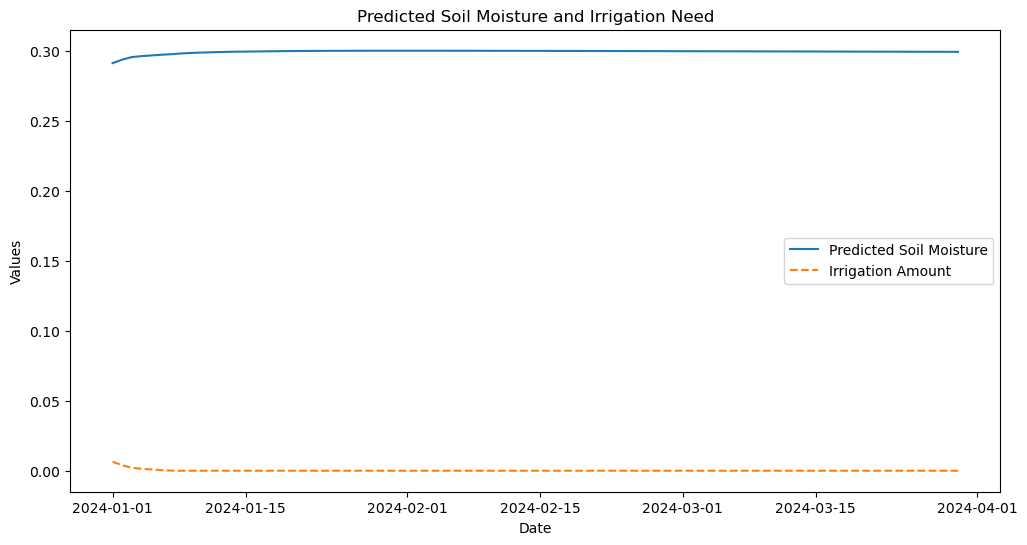

In [ ]:
# Plot the forecasted soil moisture and irrigation need
plt.figure(figsize=(12, 6))
plt.plot(irrigation_schedule.index, irrigation_schedule['predicted_soil_moisture'], label='Predicted Soil Moisture')
plt.plot(irrigation_schedule.index, irrigation_schedule['irrigation_amount'], label='Irrigation Amount', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Predicted Soil Moisture and Irrigation Need')
plt.legend()
plt.show()